In [1]:
import warnings
from typing import Optional, Sequence
import numpy as np
import os
import pandas as pd
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import datetime
import importlib
import math

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchmetrics.functional import pairwise_cosine_similarity
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

import lightly
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from avalanche.training.plugins import SupervisedPlugin
from avalanche.training.templates.supervised import SupervisedTemplate
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.models.dynamic_modules import MultiTaskModule
from avalanche.models import FeatureExtractorBackbone
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    loss_metrics,
    forgetting_metrics,
    confusion_matrix_metrics,
)
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

from datasets.coil100 import Coil100Dataset
from self_supervision.ssl import BarlowTwins, SimSiam
import clp.clp
from clp.clp import CLP


In [10]:
importlib.reload(clp.clp)
from clp.clp import CLP

root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
dataset_dir = '/home/ehajizad/ss_learning/ssl_tests/datasets/coil-100'

model_name = "coil100_simsiam_resnet9"
n_classes = 100
test_size = 0.9
train_size = 1 - test_size

train_ds = Coil100Dataset(root_dir=dataset_dir, obj_list = np.arange(n_classes),
                          transform=transforms.ToTensor(), size=64,
                          train=True, test_size=test_size)
test_ds = Coil100Dataset(root_dir=dataset_dir,obj_list = np.arange(n_classes),
                         transform=transforms.ToTensor(), size=64,
                         train=False, test_size=test_size)

coil100_nc_bm = nc_benchmark(
        train_ds, test_ds, n_experiences=n_classes, shuffle=False,
        task_labels=False,
)


device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = lightly.models.ResNetGenerator('resnet-9')
model = nn.Sequential(*list(resnet.children())[:-1],
                         nn.AdaptiveAvgPool2d(2))

# backbone = CoilCNNBackbone(in_channels = 3)

# simpleCNN = SimpleCNN()
# backbone = nn.Sequential(*list(simpleCNN.children())[:-1][0][:-2],
# nn.AdaptiveAvgPool2d(2))

model = model.to(device)
model.eval()
model.load_state_dict(torch.load(
        root_dir+"/models/"+model_name+".pth",
        map_location=device))
# model = nn.Sequential(*list(model.backbone), nn.Flatten())

# model = model[0:-1] # take final conv layer, throw away the the last pooling layer

# embeddings = np.load(
#         root_dir+"/embeddings/coil100_bt_resnet_embeddings.npz")
# X = torch.from_numpy(embeddings["X"])
# y = torch.from_numpy(embeddings["y"])

# Generate embedding

feat_ext_dl = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=4)

embeddings = []
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        embeddings.append(emb)

embeddings = torch.cat(embeddings, 0)
# feature_size = 32768

alpha_start_list = [0.5]
tau_alpha_decay_list = [3]
tau_alpha_growth_list = [3]
sim_th_list = [-6]
w_max = 5
w_min = 0

grid_search = []
for sim_th in sim_th_list:
    for alpha_start in alpha_start_list: 
        for tau_alpha_decay in tau_alpha_decay_list:
            for tau_alpha_growth in tau_alpha_growth_list:

                log_dir = "logs/coil_100/" +  "cosine_" + model_name + "_sim_th=" +str(sim_th) + \
                "_a+="+str(alpha_start) + "_tau_dc=" + str(tau_alpha_decay) + "_tau_gr=" + str(tau_alpha_growth) + \
                "__" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                
                log_dir = "logs/coil_100_clean/" + "clp_test_size=0.9__sim_th=-6__max_miss=4_euclidean" 

                eval_plugin = EvaluationPlugin(
                        accuracy_metrics(experience=True, stream=True),
                        forgetting_metrics(experience=True, stream=True),
                        confusion_matrix_metrics(num_classes=coil100_nc_bm.n_classes, save_image=False, stream=True),
                        loggers=[TensorboardLogger(log_dir)],
                )

                # CREATE THE STRATEGY INSTANCEi

                clvq = CLP(clvq_model=model,
                           n_protos=1000,
                           bmu_metric="euclidean",
                           criterion=None,
                           alpha_start=alpha_start,
                           tau_alpha_decay=tau_alpha_decay,
                           tau_alpha_growth=tau_alpha_growth,
                           sim_th=sim_th,
                           w_max=w_max,
                           w_min=w_min,
                           max_allowed_mistakes=4,
                           input_size=embeddings.shape[1],
                           num_classes=n_classes,
                           eval_mb_size=math.ceil(72*test_size),
                           train_mb_size=math.ceil(72*train_size),
                           train_epochs=1,
                           device=device,
                           evaluator=eval_plugin)

                clvq.init_prototypes_from_data(embeddings)

                # TRAINING LOOP
                n_loops = 1
                print("Starting experiment...")
                for loop in range(1,n_loops+1):
                    for i, exp in enumerate(coil100_nc_bm.train_stream):

                        # fit SLDA model to batch (one sample at a time)
                        clvq.train(exp)

                        # evaluate model on test data
                        results = clvq.eval(coil100_nc_bm.test_stream[:min(loop*(i+1),n_classes)])
                        
                acc = results['Top1_Acc_Stream/eval_phase/test_stream/Task000']

                grid_search.append([sim_th, alpha_start, tau_alpha_decay, tau_alpha_growth, np.round(acc,2)])


100%|██████████| 7200/7200 [00:00<00:00, 601465.65it/s]
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:81: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  warnings.warn(


Starting experiment...


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:228: UserWarning: Evaluation stream is not equal to the complete test stream. This may result in inconsistent metrics. Use at your own risk.
  warnings.warn(msgw)


In [7]:
grid_search = np.array(grid_search)
print(grid_search)

[[-8.    0.5   3.    3.    0.88]]


In [9]:
fig, axs = plt.subplots(len(sim_th_list),len(alpha_start_list), figsize=(25,15))
axes = axs.ravel()
x_len = len(tau_alpha_growth_list)
y_len = len(tau_alpha_decay_list)
grid_size = x_len * y_len
x = np.arange(x_len)
y = np.arange(y_len)
for i, ax in enumerate(axes):
    im = ax.imshow(grid_search[grid_size*i:grid_size*(i+1),4].reshape(y_len ,x_len), vmin=0.7, vmax=1)
    ax.set_yticks(y, tau_alpha_decay_list)
    ax.set_xticks(x, tau_alpha_growth_list)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("tau_alpha_decay", fontsize=20)
    ax.set_xlabel("tau_alpha_growth", fontsize=20)

cols = ['Alpha={}'.format(col) for col in alpha_start_list]
rows = ['Sim_th={}'.format(row) for row in sim_th_list]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=20, pad=40)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, fontsize=20, labelpad=70)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

# fig.tight_layout()
plt.show()

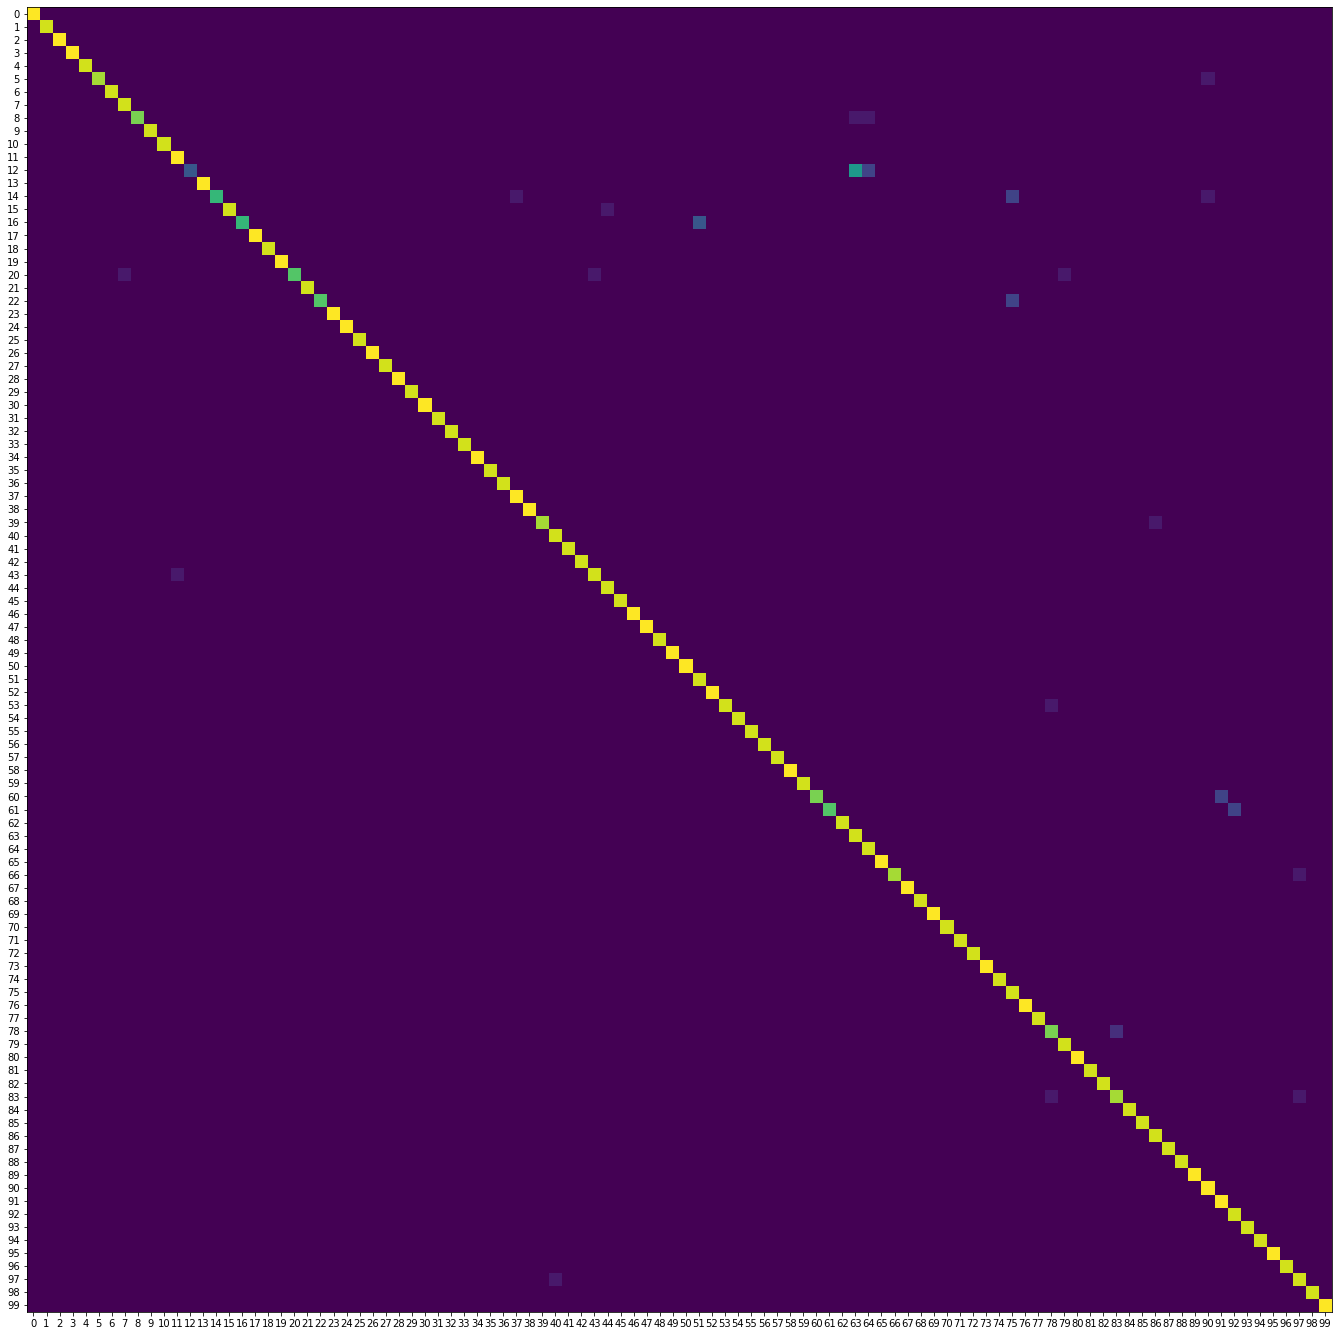

In [4]:
plt.figure(figsize=(24,24))
cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"]
plt.imshow(cm)
plt.xticks(np.arange(100))
plt.yticks(np.arange(100))
# plt.grid()
plt.show()

In [5]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
len(alloc_protos)

159

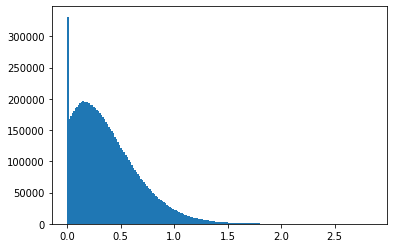

In [214]:
flat_features = features.flatten()
plt.figure()
plt.hist(flat_features, 200)
plt.show()

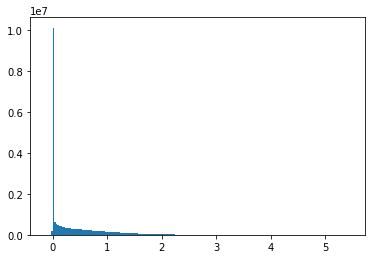

In [254]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
alloc_protos = alloc_protos.flatten()
plt.figure()
plt.hist(alloc_protos, 200)
plt.show()

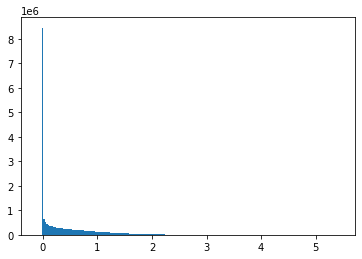

In [256]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
alloc_protos = alloc_protos.flatten()
plt.figure()
plt.hist(alloc_protos, 200)
plt.show()

In [15]:
if torch.count_nonzero(clvq.prototypes[100] >1) > 0:
    print("yes")

yes


In [265]:
clvq.prototypes[0][(clvq.prototypes[0] < w_min).nonzero()] = w_min

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [20]:
dp_sims = []
for sim in clvq.sims:
    dp_sims.extend(sim.values.cpu())
dp_sims = np.array(dp_sims)
dp_sims.shape

(154308,)

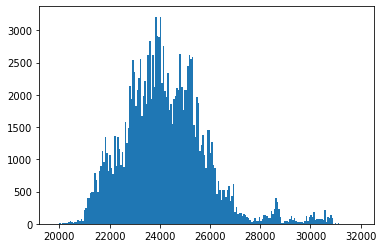

In [ ]:
plt.figure()
plt.hist(dp_sims, 200)
plt.show()

In [ ]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
len(alloc_protos)

608

In [6]:
full_ds = Coil100Dataset(root_dir=dataset_dir, obj_list = np.arange(n_classes),
                         transform=transforms.ToTensor(), size=64,
                         train=False, test_size=0.98)

feat_ext_dl = DataLoader(full_ds, batch_size=1, shuffle=False, num_workers=4)

embeddings = []
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        embeddings.append(emb)

embeddings = torch.cat(embeddings, 0)

100%|██████████| 7200/7200 [00:00<00:00, 600496.89it/s]


In [7]:
from sklearn.decomposition import PCA


# simSiam_con_emb = np.load('simSiam_con_emb.npz') 
# features = simSiam_con_emb['X'][:n_classes*72,:]
# all_targets = simSiam_con_emb['y'][:n_classes*72]
features = embeddings.cpu()
all_targets = full_ds.targets
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
emb_and_protos = np.concatenate((features,alloc_protos), 0)

# pca = PCA(n_components=100)
# pca_result = pca.fit_transform(emb_and_protos)
# print('Cumulative explained variation: {}'.format(np.sum(pca.explained_variance_ratio_)))

In [8]:
embeddings.shape

torch.Size([7056, 2048])

In [9]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto', n_jobs=-1, n_iter_without_progress=100, verbose=2,
                 init='pca', perplexity=70, n_iter=1600, metric='cosine').fit_transform(emb_and_protos)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 7346 samples in 0.018s...
[t-SNE] Computed neighbors for 7346 samples in 3.510s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7346
[t-SNE] Computed conditional probabilities for sample 2000 / 7346
[t-SNE] Computed conditional probabilities for sample 3000 / 7346
[t-SNE] Computed conditional probabilities for sample 4000 / 7346
[t-SNE] Computed conditional probabilities for sample 5000 / 7346
[t-SNE] Computed conditional probabilities for sample 6000 / 7346
[t-SNE] Computed conditional probabilities for sample 7000 / 7346
[t-SNE] Computed conditional probabilities for sample 7346 / 7346
[t-SNE] Mean sigma: 0.018595
[t-SNE] Computed conditional probabilities in 0.434s


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 62.0582123, gradient norm = 0.0141852 (50 iterations in 13.310s)
[t-SNE] Iteration 100: error = 61.8851242, gradient norm = 0.0025448 (50 iterations in 12.920s)
[t-SNE] Iteration 150: error = 62.0708580, gradient norm = 0.0017334 (50 iterations in 12.863s)
[t-SNE] Iteration 200: error = 62.2891884, gradient norm = 0.0011368 (50 iterations in 12.878s)
[t-SNE] Iteration 250: error = 62.3499146, gradient norm = 0.0007904 (50 iterations in 12.752s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.349915
[t-SNE] Iteration 300: error = 1.4858204, gradient norm = 0.0014237 (50 iterations in 12.714s)
[t-SNE] Iteration 350: error = 0.9951653, gradient norm = 0.0005958 (50 iterations in 12.848s)
[t-SNE] Iteration 400: error = 0.8046000, gradient norm = 0.0003291 (50 iterations in 12.597s)
[t-SNE] Iteration 450: error = 0.7076073, gradient norm = 0.0002169 (50 iterations in 12.451s)
[t-SNE] Iteration 500: error = 0.6486299, gradient norm = 0.000

In [16]:
proto_label

array([  0.,   0.,   0., ..., 100., 100., 100.])

[Text(0.5, 1.0, 'Coil-100 data T-SNE projection')]

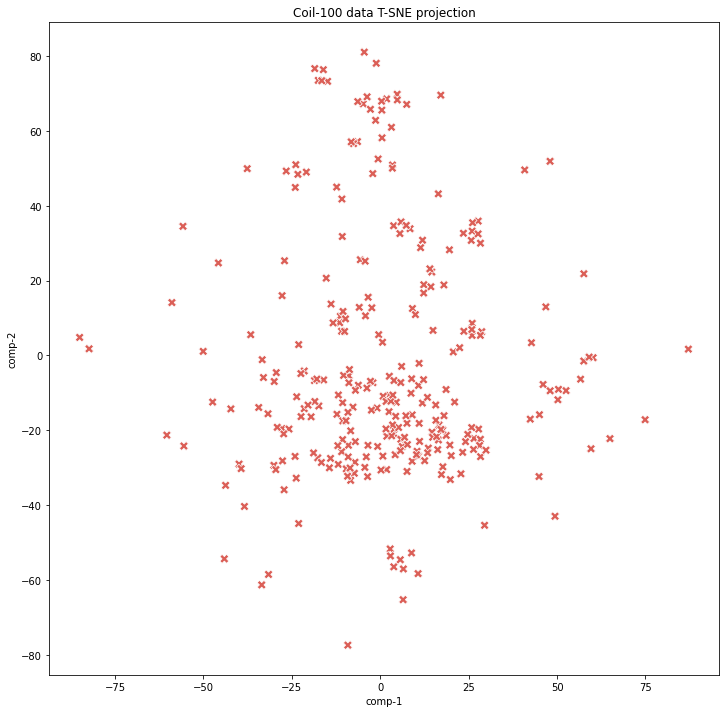

In [26]:
import seaborn as sns
y = np.concatenate((all_targets, n_classes*np.ones((len(alloc_protos),))))
proto_label = y.copy()
proto_label[proto_label<n_classes] = 0
df = pd.DataFrame()
df["y"] = y.astype(int)
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]
plt.figure(figsize=(12,12))
# ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), style=proto_label, s=80,
#                     palette=sns.color_palette("hls", n_classes+1), legend=False,
#                     data=df)
df = df[df["y"]==100]
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), marker="X", s=80,
                    palette=sns.color_palette("hls", 1), legend=False,
                    data=df)


ax.set(title="Coil-100 data T-SNE projection") 

# a = pd.concat({'x': df["comp-1"], 'y': df["comp-2"], 'label': df["y"]}, axis=1)
# a = a.sample(frac=0.02, replace=True, random_state=1)
# for i, point in a.iterrows():
#     ax.text(point['x']+.02, point['y'], str(point['label'].astype(int)))

/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to

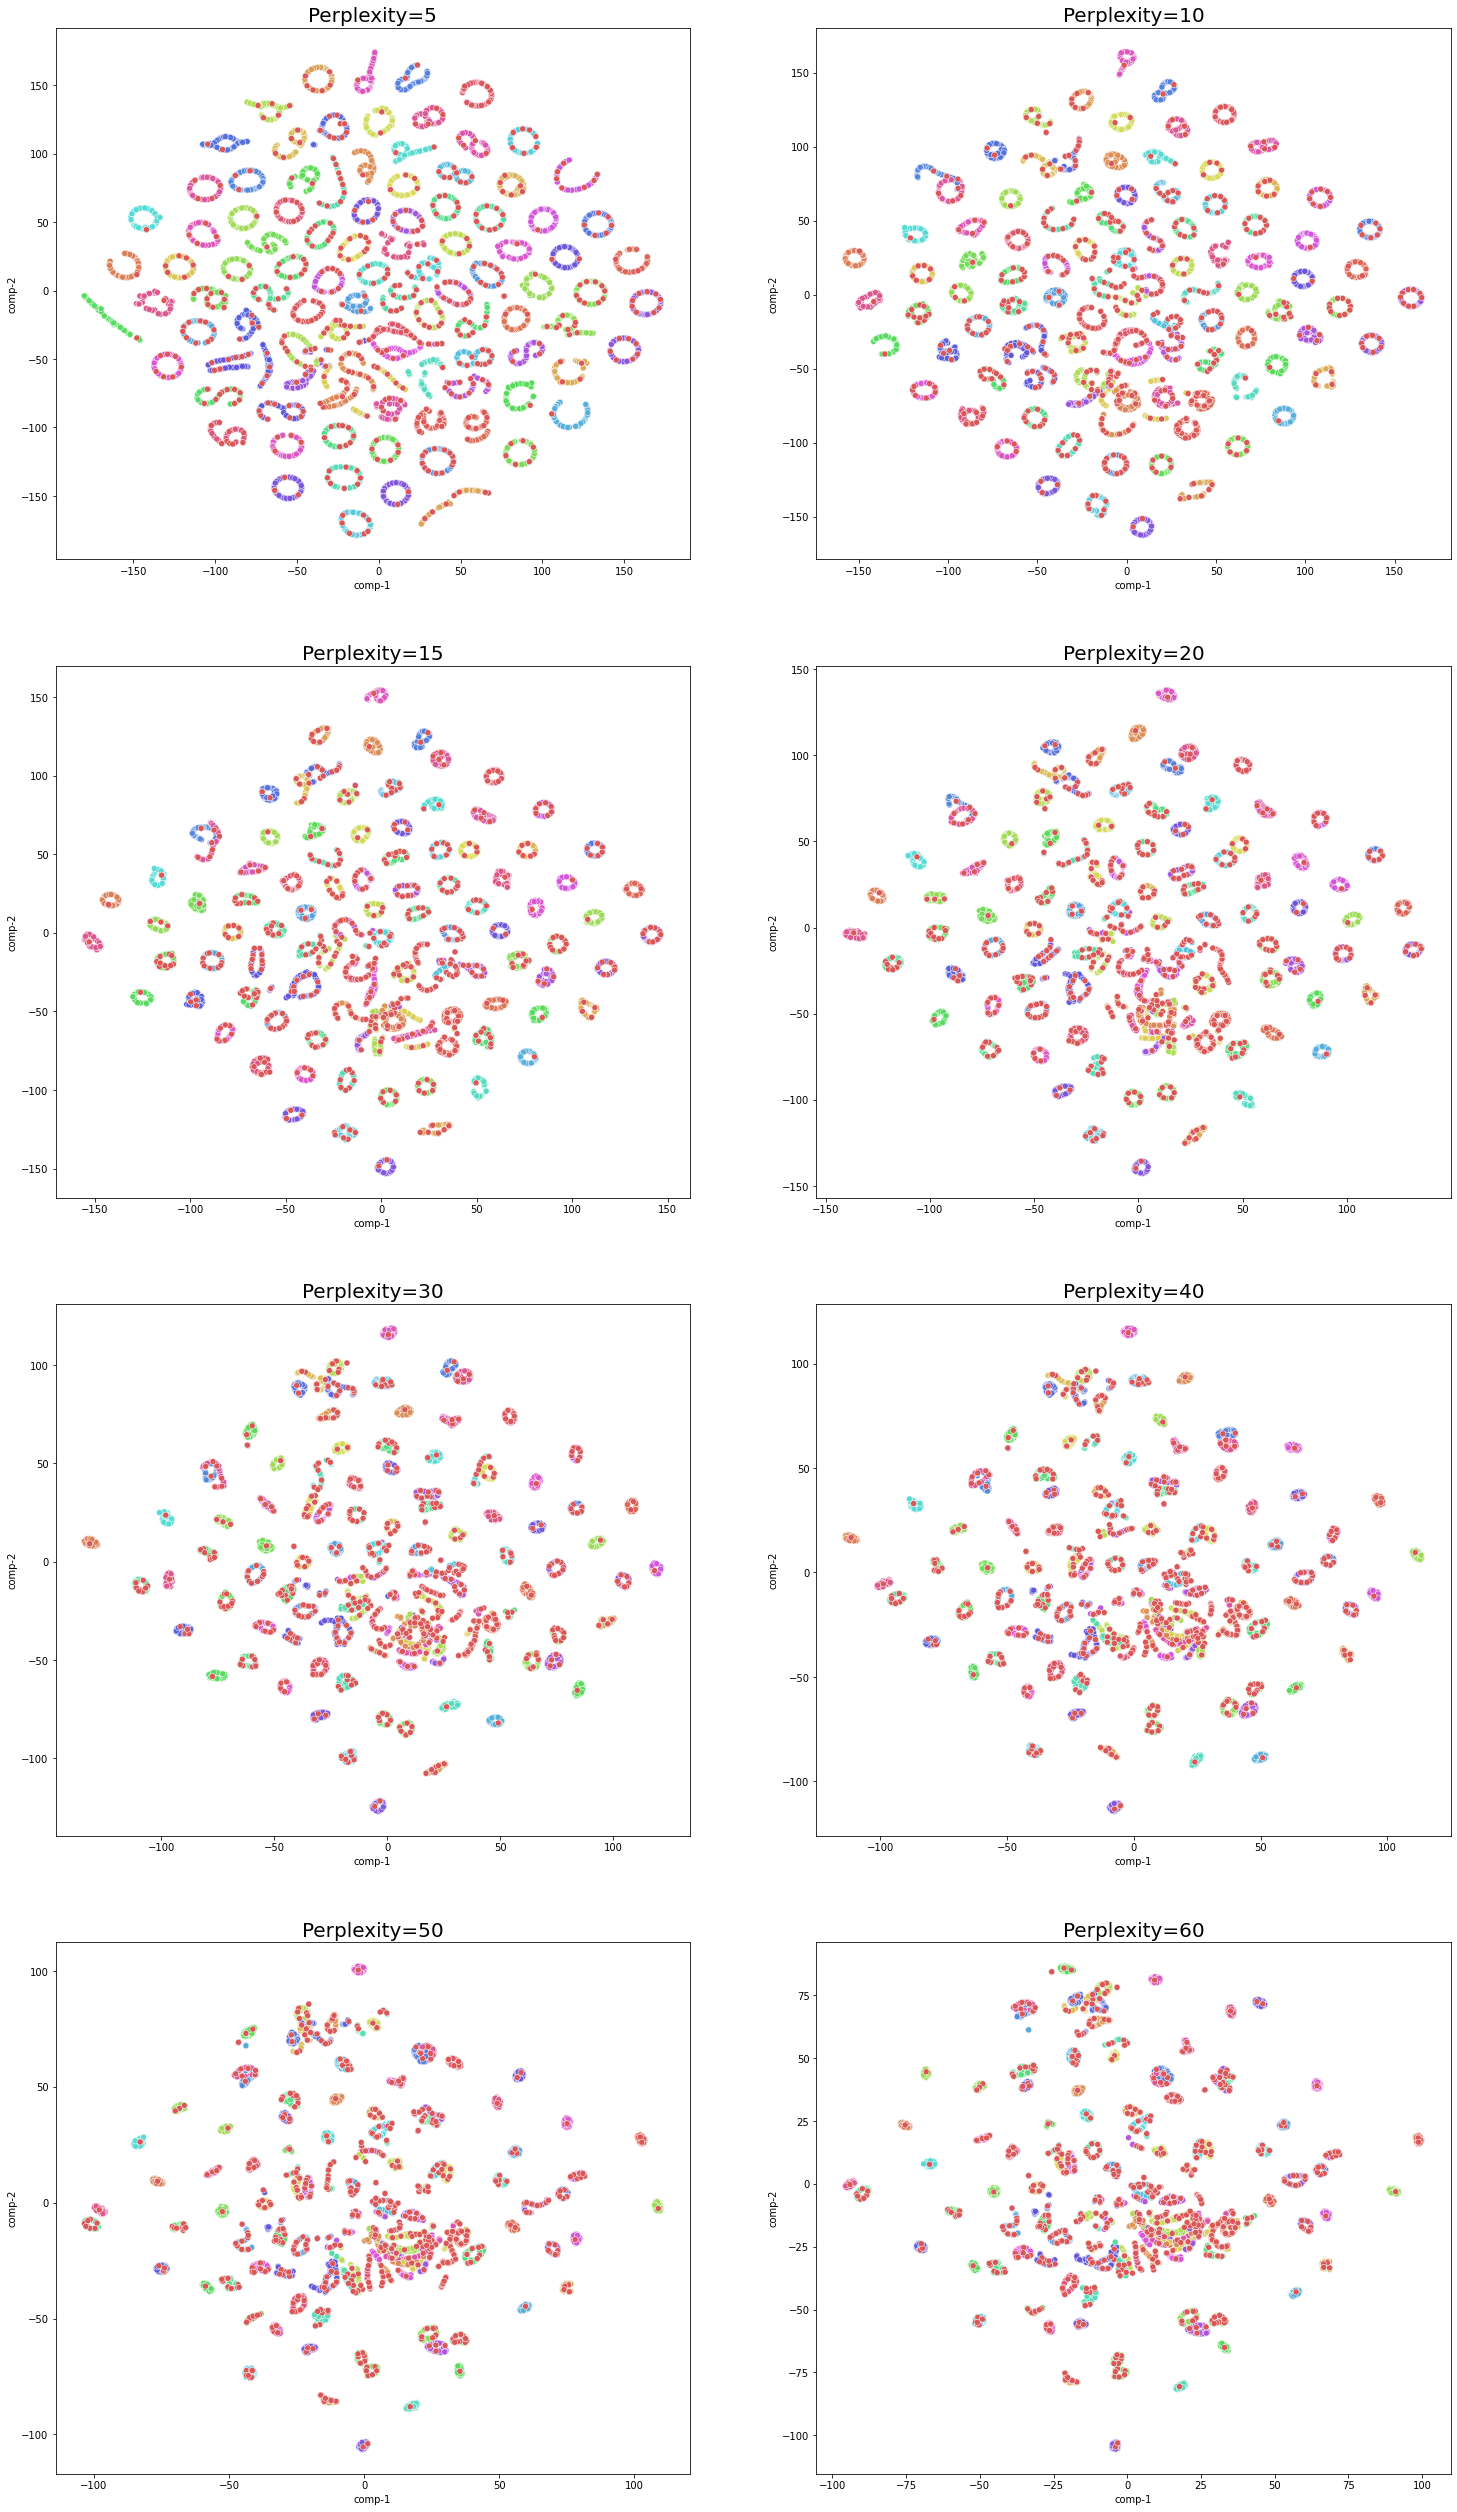

In [24]:
import seaborn as sns
fig, axes = plt.subplots(4, 2, figsize=(25,45))
axes=axes.ravel()
df = pd.DataFrame()
df["y"] = y
perp_values = [5,10,15,20,30,40,50,60]
for i, p in enumerate(perp_values):
    X_tsne = TSNE(n_components=2, learning_rate='auto',metric='cosine',
                 init='pca', perplexity=p, n_iter=2000, n_iter_without_progress=100).fit_transform(emb_and_protos)
    df["comp-1"] = X_tsne[:,0]
    df["comp-2"] = X_tsne[:,1]
    axes[i].set_title("Perplexity="+str(p), fontsize=20)
    plt.sca(axes[i])
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", n_classes+1),legend=False,
                    data=df)

In [ ]:
torch.min(clvq.prototypes)

In [ ]:
for i, exp in enumerate(coil100_nc_bm.train_stream):
    print(exp.classes_in_this_experience)

In [ ]:
results=clvq.eval(coil100_nc_bm.test_stream)

In [ ]:
with open('clp_cosine.pkl', 'wb') as f:
    pickle.dump(results, f)
        
# with open('clp_cosine.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
plt.figure(figsize=(16,16))
cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"]
plt.imshow(cm)
results["Top1_Acc_Stream/eval_phase/test_stream/Task000"]

In [8]:
%load_ext tensorboard

In [9]:
%tensorboard --logdir 'logs/coil_100_clean/' --port 6009